## Fastext своими руками

Fastext использует те же самые алгоритмы, что и word2vec. Единственное (но очень значимое) отличие в том, что в fastext используются не только слова, но и символьные нграммы. Это частично помогает решить проблему с несловарными словами. Если в словаре word2vec модели нет нужного слова, то никакого вектора для него создать не получится. В fastext же, если слова нет в словаре целиком, то можно проверить по словарю символьные нграммы этого слова и составить итоговый вектор из них. Большинство несловарных слов сильно пересекаются со словарными (основами, аффиксами) и за счет этого найденный вектор получается достаточно хороший.
Реализовать простую версию fastext немного сложнее, поэтому я вынес его в отдельный ноутбук.

In [1]:
# import tensorflow as tf
import numpy as np
import pandas as pd
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_distances

from IPython.display import Image
from IPython.core.display import HTML
%matplotlib inline


In [2]:
import os
os.environ["KERAS_BACKEND"] = "torch"
# os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

import torch
# torch.set_default_device('cpu')

import keras
print(keras.__version__)

3.8.0


Возьмем тот же небольшой кусок википедии

In [4]:
# в нашем корпусе 20к текстов
wiki = open('wiki_data.txt').read().split('\n')

In [5]:
wiki[0]

'######Новостройка (Нижегородская область)############Новостро́йка — сельский посёлок в Дивеевском районе Нижегородской области. Входит в состав Сатисского сельсовета.############Посёлок расположен в 12,5 км к югу от села Дивеева и 1 км к западу от города Сарова, на правом берегу реки Вичкинза (правый приток реки Сатис). Окружён смешанными лесами. Соединён асфальтовой дорогой с посёлком Цыгановка (1,5 км) и грунтовыми просёлочными дорогами с посёлком Сатис (3,5 км). Название Новостройка является сугубо официальным, местное население использует исключительно альтернативное название — Хитрый. Употребляется языковой оборот «…на Хитром». Ранее используемые названия — Песчаный, Известковый.############Основан в 1920-х годах переселенцами из соседних сёл Аламасово и Нарышкино (расположенных соответственно в 8 и 14 км к западу в Вознесенском районе).############Традиционно в посёлке жили рабочие совхоза «Вперёд» (центр в посёлке Сатис). Возле посёлка расположен карьер где активно добывали дол

In [6]:
len(wiki)

20003

Базовая токенизация остается точно такой же

In [7]:
import re
from collections import Counter
def tokenize(text):
    tokens = re.sub('#+', ' ', text.lower()).split()
    tokens = [token.strip(punctuation) for token in tokens]
    tokens = [token for token in tokens if token]
    return tokens


Второй базовый элемент - это нграммер, чтобы разбивать токен на символьные нграммы
Обратите внимание что к токену добавляются <> чтобы учесть в нграммах, что они стоят в начале или в конце

In [8]:
def ngrammer(raw_string, n=2):
    ngrams = []
    raw_string = ''.join(['<', raw_string, '>'])
    for i in range(0,len(raw_string)-n+1):
        ngram = ''.join(raw_string[i:i+n])
        if ngram == '<' or ngram == '>': # сами по себе <> как токены не нужны
            continue
        ngrams.append(ngram)
    return ngrams

Следующая функция проходится по токенам и разбивает каждый токен на подсимвольные нграммы в заданном интервале

In [9]:
def split_tokens(tokens, min_ngram_size, max_ngram_size):
    tokens_with_subwords = []
    for token in tokens:
        subtokens = []
        for i in range(min_ngram_size, max_ngram_size+1):
            if len(token) > i:
                subtokens.extend(ngrammer(token, i))
        tokens_with_subwords.append(subtokens)
    return tokens_with_subwords


In [10]:
split_tokens(['подсимвольные', 'нграммы'], 3, 4)

[['<по',
  'под',
  'одс',
  'дси',
  'сим',
  'имв',
  'мво',
  'вол',
  'оль',
  'льн',
  'ьны',
  'ные',
  'ые>',
  '<под',
  'подс',
  'одси',
  'дсим',
  'симв',
  'имво',
  'мвол',
  'воль',
  'ольн',
  'льны',
  'ьные',
  'ные>'],
 ['<нг',
  'нгр',
  'гра',
  'рам',
  'амм',
  'ммы',
  'мы>',
  '<нгр',
  'нгра',
  'грам',
  'рамм',
  'аммы',
  'ммы>']]

Теперь нам нужно спаппить токены и подсимвольные нграммы в индексы и для этого нужно построить словарь. Это немного сложнее чем раньше потому что мы хотим иметь в словаре и полные слова и символьные нграммы, но нам нужно иметь отдельный список только полных слов, чтобы потом иметь возможность находить ближайшие слова.

Чтобы было удобнее со всеми переменными напишем класс для токенизации

In [11]:
class SubwordTokenizer:
    def __init__(self, ngram_range=(1,1), min_count=5):
        self.min_ngram_size, self.max_ngram_size = ngram_range
        self.min_count = min_count
        self.subword_vocab = None
        self.fullword_vocab = None
        self.vocab = None
        self.id2word = None
        self.word2id = None

    def build_vocab(self, texts):
        # чтобы построить словарь нужно пройти по всему корпусу и собрать частоты всех уникальных слов и нграммов
        unfiltered_subword_vocab = Counter()
        unfiltered_fullword_vocab = Counter()
        for text in texts:
            tokens = tokenize(text)
            unfiltered_fullword_vocab.update(tokens)
            subwords_per_token = split_tokens(tokens, self.min_ngram_size, self.max_ngram_size)
            for subwords in subwords_per_token:
                # в одном слове могут быть одинаковые нграммы поэтому возьмем только уникальные
                unfiltered_subword_vocab.update(set(subwords))

        self.fullword_vocab = set()
        self.subword_vocab = set()

        # теперь отфильтруем по частоте
        for word, count in unfiltered_fullword_vocab.items():
            if count >= self.min_count:
                self.fullword_vocab.add(word)
        # для нграммов сделаем порог побольше чтобы не создавать слишком много нграммов
        # и учитывать только действительно частотные
        for word, count in unfiltered_subword_vocab.items():
            if count >= (self.min_count * 100):
                self.subword_vocab.add(word)

        # общий словарь
        self.vocab = self.fullword_vocab | self.subword_vocab
        self.id2word = {i:word for i,word in enumerate(self.vocab)}
        self.word2id = {word:i for i,word in self.id2word.items()}

    def subword_tokenize(self, text):
        if self.vocab is None:
            raise AttributeError('Vocabulary is not built!')
        # разбиваем на токены
        tokens = tokenize(text)
        # каждый токен разбиваем на символьные нграммы
        tokens_with_subwords = split_tokens(tokens, self.min_ngram_size, self.max_ngram_size)
        # оставляет только токены и нграммы которые есть в словаре
        only_vocab_tokens_with_subwords = []
        for full_token, sub_tokens in zip(tokens, tokens_with_subwords):
            filtered = []
            if full_token in self.vocab:
                # само слово и нграммы хранятся в одном списке
                # но слово будет всегда первым в списке
                filtered.append(full_token)
            filtered.extend([subtoken for subtoken in set(sub_tokens) if subtoken in self.vocab])
            only_vocab_tokens_with_subwords.append(filtered)

        return only_vocab_tokens_with_subwords

    def encode(self, subword_tokenized_text):
        # маппим токены и нграммы в их индексы в словаре
        encoded_text = []
        for token in subword_tokenized_text:
            if not token:
                continue
            encoded_text.append([self.word2id[token[0]]] + [self.word2id[t] for t in set(token[1:]) if t in self.word2id and t != token[0]])
        return encoded_text

    def __call__(self, text):
        return self.encode(self.subword_tokenize(text))


In [12]:
tokenizer = SubwordTokenizer(ngram_range=(2,4), min_count=10)

In [13]:
tokenizer.build_vocab(wiki)

In [14]:
tokenizer.subword_tokenize('Текст для тестирования токенизации')

[['текст',
  'ст',
  '<тек',
  'ек',
  'тек',
  'кст',
  'текс',
  'ст>',
  'те',
  'екс',
  '<т',
  'т>',
  '<те',
  'екст',
  'кс'],
 ['для', 'дл', 'я>', 'ля', '<д'],
 ['тестирования',
  'ован',
  'ания',
  'ия',
  'тес',
  'ия>',
  'ния>',
  'ст',
  'ро',
  'рова',
  'ест',
  '<т',
  'ров',
  'ир',
  'ани',
  'я>',
  'ес',
  'ния',
  'тир',
  '<те',
  'ва',
  'ести',
  'иро',
  'иров',
  'ан',
  'ван',
  'ов',
  'тест',
  'тиро',
  'ова',
  'сти',
  'вани',
  'ти',
  'те',
  'ни'],
 ['иза',
  'низа',
  'кен',
  'ен',
  'заци',
  'ке',
  'ии>',
  'ации',
  'токе',
  'из',
  'ац',
  'ок',
  'то',
  'ток',
  '<т',
  'ии',
  'оке',
  '<то',
  'ции>',
  'ци',
  'изац',
  'за',
  'ени',
  'ции',
  'ни',
  'низ',
  'и>',
  'аци',
  'зац']]

In [17]:
len(tokenizer.vocab)

54860

In [18]:
tokenizer('Текст для тестирования токенизации')

[[32047,
  48929,
  9723,
  48462,
  14216,
  43720,
  24395,
  45617,
  29732,
  1615,
  36156,
  34740,
  21774,
  10969,
  16178],
 [41158, 40212, 17938, 23853, 43107],
 [20122,
  6741,
  3931,
  36210,
  29693,
  40934,
  27179,
  48929,
  2881,
  47426,
  29088,
  36156,
  3217,
  11633,
  33638,
  17938,
  18933,
  13853,
  11138,
  21774,
  3914,
  13522,
  9243,
  8318,
  4602,
  6508,
  41493,
  517,
  46963,
  54664,
  35388,
  92,
  31625,
  29732,
  29834],
 [21735,
  42059,
  18566,
  37428,
  19402,
  17247,
  48252,
  36960,
  21459,
  28392,
  44155,
  17646,
  23332,
  169,
  36156,
  5862,
  8353,
  20507,
  34974,
  47500,
  9616,
  4500,
  20779,
  26470,
  29834,
  5289,
  39462,
  48466,
  9922]]

Реализуем функцию которая будет генерировать батчи для обучения. Сделаем только скипграмм алгоритм. То есть нам нужны пары токен_1 - токен_2 встретившиеся в одном контексте, только для токена_1 мы еще будет учитывать его символьный нграммы, а токен_2 будет предсказывать только целиком без разбиение на поднграммы

In [19]:
def gen_batches_ft(sentences, tokenizer, window = 5, batch_size=1000, maxlen=20):


    left_context_length = (window/2).__ceil__()
    right_context_length = window // 2

    while True:
        X = []
        y = []

        for sent in sentences:
            sent = tokenizer(sent)
            for i in range(len(sent)-1):
                word_with_subtokens = sent[i]
                context = sent[max(0, i-left_context_length):i] + sent[i+1:i+right_context_length]
                for context_word_with_subtokens in context:
                    # целевой токен всегда только целый
                    # мы берем первый токен из списка который вернул токенайзер
                    # там у нас будет лежать целое слово
                    only_full_word_context_token = context_word_with_subtokens[0]
                    X.append(word_with_subtokens)
                    y.append(only_full_word_context_token)

                    if len(X) >= batch_size:
                        # тут нам понадобится паддинг так как количество сивольных нграммов будет зависеть от длины токенов
                        X = np.array(keras.preprocessing.sequence.pad_sequences(X, maxlen=maxlen))
                        y = np.array(y)
                        yield (X, y)
                        X = []
                        y = []

In [20]:
gen = gen_batches_ft(wiki, tokenizer, batch_size=5)

In [21]:
next(gen)

(array([[ 2881, 15696, 36218, 39612, 37544, 21529, 41064, 45042, 13847,
          5320, 13635,  4644, 29504, 51020, 20222,  4870, 41493, 37669,
         11385,  3770],
        [39723, 25845, 53797, 41064, 21879, 50968, 17938, 24886, 12777,
         44064, 35966, 23514, 48686,  4870, 15609, 31382, 29834, 38748,
           924, 33550],
        [39723, 25845, 53797, 41064, 21879, 50968, 17938, 24886, 12777,
         44064, 35966, 23514, 48686,  4870, 15609, 31382, 29834, 38748,
           924, 33550],
        [52081, 13337,  3518, 48929, 27301,  3474, 49923, 47585, 38009,
         11756, 50349,  3427, 13585, 29827, 32042, 34718, 29404, 22681,
         40654, 15618],
        [52081, 13337,  3518, 48929, 27301,  3474, 49923, 47585, 38009,
         11756, 50349,  3427, 13585, 29827, 32042, 34718, 29404, 22681,
         40654, 15618]], dtype=int32),
 array([ 6449, 28929, 47718, 28929,  6449]))

Код для обучения очень простой. Мы просто сопостовляет каждому токену и нграмму эмбединг и усредняем все эмбединги внутри слова, чтобы получить итоговый. По нему мы пытаемся предсказать целевое слово.

In [22]:
model = keras.Sequential()
model.add(keras.layers.Embedding(input_dim=len(tokenizer.vocab),
                                 output_dim=100))
model.add(keras.layers.Lambda(lambda x: x.mean(axis=1)))

model.add(keras.layers.Dense(len(tokenizer.vocab), activation='softmax'))
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy')

In [23]:
model.build((None, 10))

In [24]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 10, 100)        │     5,486,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 54860)          │     5,540,860 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,026,860 (42.06 MB)

 Trainable params: 11,026,860 (42.06 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
model.fit(gen_batches_ft(wiki[:19000],tokenizer, window=10, batch_size=100),
          validation_data=gen_batches_ft(wiki[19000:], tokenizer, window=10, batch_size=100),
          batch_size=2000,
          steps_per_epoch=10000,
          validation_steps=100,
          epochs=2)

Epoch 1/2
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 4446s 444ms/step - loss: 8.9270 - val_loss: 9.1557
Epoch 2/2
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 3755s 376ms/step - loss: 8.8052 - val_loss: 9.0009


dict_keys(['loss', 'val_loss'])


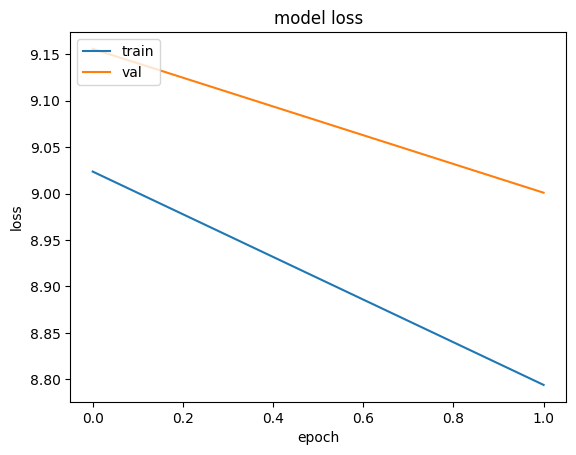

In [28]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Искать похожие немного сложнее так как нам нужно для всех полных слов еще и учесть информацию об их поднграммах.

In [29]:
embeddings = model.layers[0].get_weights()[0] # матрица со всеми эмбедингами

In [30]:
full_word_embeddings = np.zeros((len(tokenizer.fullword_vocab), 100)) # матрица с эмбедингами полных слов + нграммы
id2word = list(tokenizer.fullword_vocab)

for i, word in enumerate(tokenizer.fullword_vocab):
    subwords = tokenizer(word)[0]
    full_word_embeddings[i] = embeddings[[i for i in subwords]].mean(axis=0)

In [31]:
def most_similar_ft(word, embeddings, tokenizer):
    subwords = tokenizer(word)[0]
    word_embedding = embeddings[[i for i in subwords]].sum(axis=0)
    # idxs = [tokenizer.word2id[i] for i in tokenizer.fullword_vocab]
    similar = [id2word[i] for i in
               cosine_distances(word_embedding.reshape(1, -1), full_word_embeddings).argsort()[0][:20]]
    return similar

Из результатов поиска видно что fastext учитывает поднграмы и находит как ближайшие не только близкие по смыслу но и по форме

In [32]:
most_similar_ft('семья', embeddings, tokenizer)

['семья',
 'семьях',
 'семье',
 'семь',
 'семьям',
 'семью',
 'семьёй',
 'семьями',
 'семьей',
 'семьи»',
 'сельскохозяйственную',
 'семьи',
 'сельскохозяйственным',
 'семеновка',
 'семеноводства',
 'секретарем',
 'семёновского',
 'значениях',
 'современниками',
 'сельскохозяйственной']

In [33]:
most_similar_ft("церковь", embeddings, tokenizer)

['церковь',
 '«церковь',
 'церковью',
 'церковном',
 'церковное',
 'церковных',
 'церковным',
 'церковные',
 'церковную',
 'церковному',
 'церковный',
 'церковной',
 'церковная',
 'церковного',
 'концертном',
 'церковно-приходская',
 'церквях',
 'атлантического',
 'атлантическом',
 'физико-математического']

In [34]:
most_similar_ft("делать", embeddings, tokenizer)

['делать',
 'сделать',
 'переделать',
 'проделать',
 'дела»',
 'дель',
 'прислать',
 'делалось',
 'делал',
 'делах',
 'дела',
 'делались',
 'делают',
 'держать',
 'выдержать',
 'делало',
 'слышать',
 'взаимодействовать',
 'платить',
 'пределах']

В тетрадку с фастекстом добавьте код для обучения с negative sampling (задача сводится к бинарной классификации) и обучите модель. Проверьте полученную модель на нескольких словах. Похожие слова должны быть похожими по смыслу и по форме.

In [35]:
def generate_negatives(pos_pairs, num_negatives, vocab_size):
    negatives = []
    for pair in pos_pairs:
        negative_samples = np.random.randint(0, vocab_size, size=num_negatives)
        negatives.extend([(pair[0], neg) for neg in negative_samples])
    return negatives

In [42]:
def gen_batches_ft(sentences, tokenizer, window=5, batch_size=1000, maxlen=20, num_negatives=5):
    left_context_length = (window / 2).__ceil__()
    right_context_length = window // 2
    vocab_size = len(tokenizer.vocab)

    while True:
        X_pos = []
        y_pos = []

        for sent in sentences:
            sent = tokenizer(sent)
            for i in range(len(sent)):
                word_with_subtokens = sent[i]
                context = sent[max(0, i - left_context_length):i] + sent[i+1:i + right_context_length + 1]

                for context_word_with_subtokens in context:
                    if not context_word_with_subtokens:  # Пропускаем пустые контексты
                        continue
                    X_pos.append(word_with_subtokens)
                    y_pos.append(context_word_with_subtokens[0])  # Берём только целое слово из контекста

                    if len(X_pos) >= batch_size:
                        X_pos_padded = keras.preprocessing.sequence.pad_sequences(
                            X_pos, maxlen=maxlen, padding='post', truncating='post'
                        )

                        y_neg = np.random.randint(0, vocab_size, size=len(X_pos) * num_negatives)
                        X_neg_padded = np.vstack([X_pos_padded] * num_negatives)  # Копируем X_pos для негативов

                        X_batch = np.vstack([X_pos_padded, X_neg_padded])
                        y_batch = np.array([1] * len(X_pos_padded) + [0] * len(X_neg_padded))

                        indices = np.arange(len(X_batch))
                        np.random.shuffle(indices)
                        X_batch = X_batch[indices]
                        y_batch = y_batch[indices]

                        yield (X_batch, y_batch)
                        X_pos = []
                        y_pos = []

Обновленная модель

In [43]:
model = keras.Sequential([
    keras.layers.Embedding(input_dim=len(tokenizer.vocab), output_dim=100),
    keras.layers.Lambda(lambda x: x.mean(axis=1)),  # Усредняем n-граммы
    keras.layers.Dense(1, activation='sigmoid')  # Бинарный классификатор
])

In [44]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [45]:
model.fit(
    gen_batches_ft(wiki[:19000], tokenizer, window=10, batch_size=100, num_negatives=10),
    validation_data=gen_batches_ft(wiki[19000:], tokenizer, window=10, batch_size=100, num_negatives=10),
    steps_per_epoch=1000,
    validation_steps=100,
    epochs=2
)

Epoch 1/2
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 107s 107ms/step - accuracy: 0.8885 - loss: 0.6152 - val_accuracy: 0.9091 - val_loss: 0.4243
Epoch 2/2
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 106s 106ms/step - accuracy: 0.9091 - loss: 0.3754 - val_accuracy: 0.9091 - val_loss: 0.3327


In [46]:
most_similar_ft("волк", embeddings, tokenizer)

['волк',
 'волков',
 'волкова',
 'волка',
 'воли',
 'волковом',
 'воле',
 'волге',
 'восстановительные',
 'волости»',
 'волшебника',
 'волшебник',
 'волн',
 'мотострелковой',
 'полководцев',
 'восстановить',
 'отделяется',
 'переговоров',
 'военно-революционного',
 'вольное']